# Logistic Regression

Import libraries

In [12]:
import pandas as pd
import numpy as np
import scipy
import json
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from matplotlib.colors import LinearSegmentedColormap


Bring in data

In [13]:
# read in sparse representation of vocabulary
sparse_matrix = scipy.sparse.load_npz('../Data/subreddit_csr_5000.npz')

# read in vocabulary itself
with open('../Data/subreddit_vocabulary_5000.json', 'r') as file:
    vocabulary = np.array(json.load(file))

# read in class labels
with open('../Data/subreddit_classes.json', 'r') as file:
    classes = np.array(json.load(file))

print('Shape of Sparse Matrix:', sparse_matrix.shape)
print('Length of Vocabulary:', vocabulary.shape)
print('Length of Classes:', classes.shape)

Shape of Sparse Matrix: (200000, 5000)
Length of Vocabulary: (5000,)
Length of Classes: (200000,)


In [14]:
# replace 'tifu' for 'timu'
classes = np.char.replace(classes, 'tifu', 'timu')
np.unique(classes)

array(['AskReddit', 'leagueoflegends', 'relationships', 'timu', 'trees'],
      dtype='<U15')

## Preprocess

In [15]:
# subset the data if needed
use_full_data = False # set to true to use full data
rows_to_subset = 50000

if use_full_data == False:
    idx = np.random.choice(sparse_matrix.shape[0], size=rows_to_subset, replace=False) # to make sure same rows get sampled from both
    X_sparse_matrix = sparse_matrix[idx,:]
    y_data = classes[idx]
elif use_full_data == True:
    X_sparse_matrix = sparse_matrix
    y_data = classes
else:
    raise ValueError("Choose true of false in 'use_full_data'")

# see shapes
print(f'X Sparse Matrix: {X_sparse_matrix.shape}')
print(f'Y Data: {y_data.shape}')


X Sparse Matrix: (50000, 5000)
Y Data: (50000,)


In [16]:
# choose class for binary classification
target_class_string_1 = "leagueoflegends"
target_class_string_2 = "trees"

In [17]:
# subset the data if needed
use_full_data = True # set to true to use full data
rows_to_subset = 20000 # from each class


if use_full_data == False:
    # get indices
    target_class_string_1_rows = np.where(classes == target_class_string_1)[0][:rows_to_subset]
    target_class_string_2_rows = np.where(classes == target_class_string_2)[0][:rows_to_subset]
    rows_to_subset = np.concatenate((target_class_string_1_rows, target_class_string_2_rows))
    
    # subset
    X_sparse_matrix = sparse_matrix[rows_to_subset, :]
    y_data = classes[rows_to_subset]
elif use_full_data == True:
    # get indices
    target_class_string_1_rows = np.where(classes == target_class_string_1)[0]
    target_class_string_2_rows = np.where(classes == target_class_string_2)[0]
    rows_to_subset = np.concatenate((target_class_string_1_rows, target_class_string_2_rows))
    
    # subset
    X_sparse_matrix = sparse_matrix[rows_to_subset, :]
    y_data = classes[rows_to_subset]
else:
    raise ValueError("Choose true or false in 'use_full_data'")

# see shapes
print(f'X Sparse Matrix: {X_sparse_matrix.shape}')
print(f'Y Data: {y_data.shape}')


X Sparse Matrix: (80000, 5000)
Y Data: (80000,)


In [18]:
# see load balance
pd.Series(y_data).value_counts()

leagueoflegends    40000
trees              40000
dtype: int64

In [19]:
# create x and y
X = X_sparse_matrix.toarray()

# encode y into numbers
encoder = LabelEncoder()
y = encoder.fit_transform(y_data)

## Model

In [20]:
# function for converting dataset into binary classification rather than multiclass
def convert_to_binary_labels(y_data, target_class_string, encoder):
    # convert string to integer
    target_class_encoded = encoder.transform([target_class_string])[0]
    # get list of true and falses
    binary_labels = (y_data == target_class_encoded).astype(int)
    return binary_labels

# test
#convert_to_binary_labels(y, "timu", encoder)

In [21]:
# other params
max_iterations = 1000
lambda_reg = 0.001
k_fold_splits = 5

# init lists
test_accuracies = []
confusion_matrix_var = []

# get binary classes from multiclass
y_binary = convert_to_binary_labels(y, target_class_string_1, encoder)

# init cross validation
strat_k_fold = StratifiedKFold(n_splits=k_fold_splits, shuffle=True, random_state=42)

for train_index, test_index in strat_k_fold.split(X, y_binary):
    # splits
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y_binary[train_index], y_binary[test_index]

    # model
    logistic_regression_model = LogisticRegression(penalty='l1', C=lambda_reg, max_iter=max_iterations, solver='liblinear') # note: default solver doesn't support L1
    logistic_regression_model.fit(X_train, y_train)

    # get accuracy
    test_accuracy = logistic_regression_model.score(X_test, y_test)
    test_accuracies.append(test_accuracy)
    y_pred = logistic_regression_model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    confusion_matrix_var.append(cm)

# Calculate the average test accuracy
avg_test_accuracy = np.mean(test_accuracies)
print(f'Average test accuracy: {avg_test_accuracy:.4f}')


Average test accuracy: 0.9178


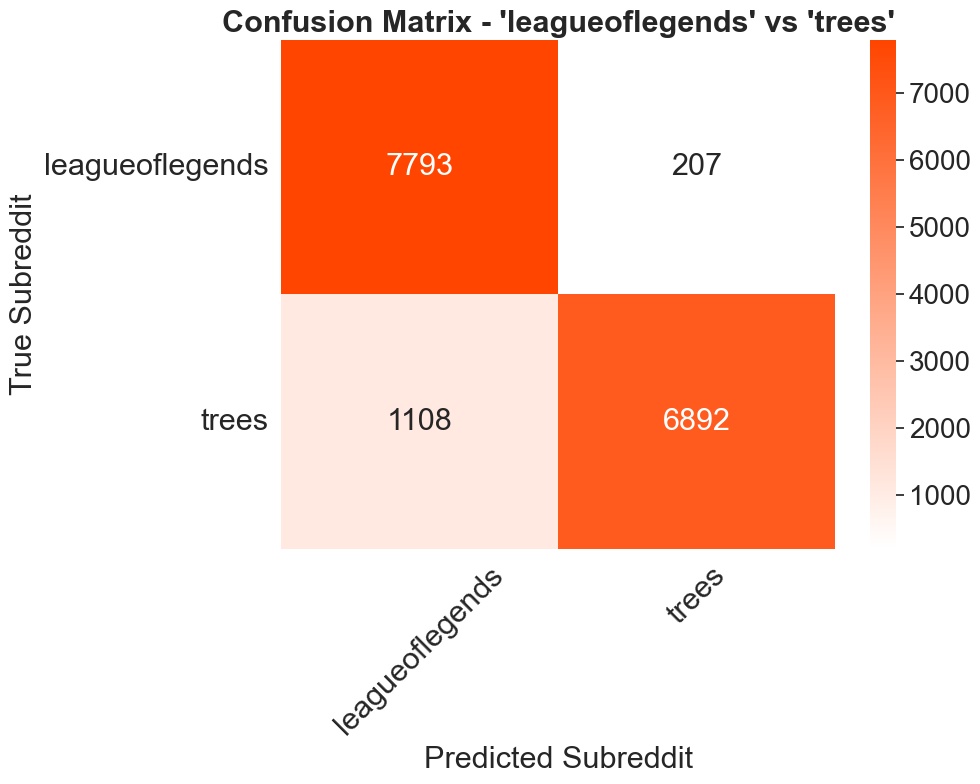

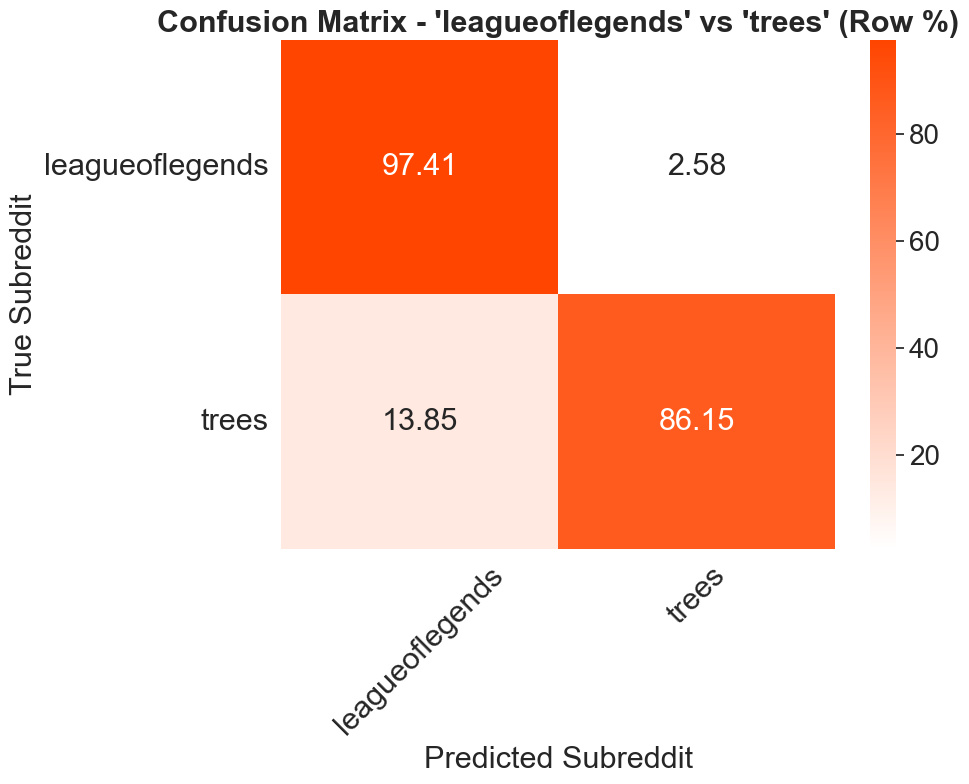

In [23]:

# matplotlib params
font_family_txt = 'Arial'
font_size_num = 22

# make confusion matric
def plot_confusion_matrix(confusion_matrix_var, target_class_string_1, target_class_string_2, cmap=LinearSegmentedColormap.from_list('', ['#FFFFFF', '#FF4500']), row_percent= False):
    
    # formatiing
    fmt='.0f'
    plot_title_text = f"Confusion Matrix - '{target_class_string_1}' vs '{target_class_string_2}'"
    savefile_name = 'logistic_confusion_matrix'

    if row_percent == True:
        confusion_matrix_var = confusion_matrix_var / confusion_matrix_var.sum(axis=1, keepdims=True) * 100
        fmt='.2f'
        plot_title_text = f"Confusion Matrix - '{target_class_string_1}' vs '{target_class_string_2}' (Row %)"
        savefile_name = 'logistic_confusion_matrix_pct'
    
    # init plot
    fig = plt.figure(figsize=(10, 8))

    sns.set()
    heatmap = sns.heatmap(confusion_matrix_var, annot=True, fmt=fmt, cmap=cmap, cbar=True,
                xticklabels=[target_class_string_1, target_class_string_2], yticklabels=[target_class_string_1, target_class_string_2], annot_kws={"fontsize":font_size_num})
    plt.xticks(rotation = 45)
    plt.yticks(rotation = 0)
    plt.title(plot_title_text, fontweight='bold', fontsize=font_size_num, fontfamily=font_family_txt)
    plt.xlabel('Predicted Subreddit', fontsize=font_size_num, fontfamily=font_family_txt)
    plt.ylabel('True Subreddit', fontsize=font_size_num, fontfamily=font_family_txt)
    heatmap.tick_params(axis='both', which='major', labelsize=font_size_num)
    cbar = heatmap.collections[0].colorbar
    cbar.ax.tick_params(labelsize=font_size_num-2)
    plt.tight_layout()
    plt.savefig(f"../Output/LogisticResults/{savefile_name}_{target_class_string_1}_{target_class_string_2}.png")
    plt.show()

# plot average of confusion matrix
average_cm = np.mean(confusion_matrix_var, axis=0)


plot_confusion_matrix(average_cm, target_class_string_1, target_class_string_2, row_percent= False)
plot_confusion_matrix(average_cm, target_class_string_1, target_class_string_2, row_percent= True)


